## TTC Headway Analysis 
By Bohan

The 'headway' is the length of time between the arrival times of two consecutive trains at a given station. Using cleansed  data from arrival_time_exploration_ver2.ipynb (Bloor-Danforth, April 2019), I intend to run similar head way analysis as Mohamed (https://github.com/moh-osman/ttc_subway_times/blob/master/doc/ttc_headway_analysis.ipynb)  
  
### Major Changes
1. Only look at Eastbound trains during 7am to 7pm, Monday to Friday
2. Ignore long headway for now


### Issues
1. Is the result realistic? (low mean waiting time and vriability at Yong and headway can be very long (e.g. over 3hrs)
2. I did not find trains with both 'train_message' == 'Delayed' and  'timint'==0  
    Will it be a problem in the future?
3. Any bugs or things we did not consider

### Import data from previous code

In [1]:
import datetime; 
import numpy as np;  # useful for many scientific computing in Python
import pandas as pd; # primary data structure library
import matplotlib.pyplot as plt; # for plotting

df = pd.read_csv('merged_2019_04.csv'); # import data from Arrival_time_exploration_ver2

df.drop(df[df['lineid']==1].index, inplace=True);
df.drop(df[df['traindirection']=='West'].index, inplace=True);
df.drop(df[pd.to_timedelta(df['time'])<pd.to_timedelta('7 hours')].index, inplace=True);
df.drop(df[pd.to_timedelta(df['time'])>pd.to_timedelta('19 hours')].index, inplace=True);
# find day of the week where Monday=0, Sunday=6
df['day_of_week'] = pd.to_datetime(df['date']).dt.dayofweek;
df.drop(df[df['day_of_week']>4].index, inplace=True);


# sort data by train direction, station, and request date (ascending)
df.sort_values(by=['traindirection','station_char','request_date'], inplace=True);
df.head(15)

,Unnamed: 0,requestid,id,station_char,subwayline,timint,traindirection,trainid,train_message,train_dest,stationid,lineid,create_date,pollid,request_date,date,time,day_of_week
1081,7374991,1303965,29391268244,BAT,BD,0.754087,East,203,Arriving,Westbound<br/> To Kipling,46,2,2019-04-01 07:00:46,18230,2019-04-01 07:00:47.319746-04:00,2019-04-01,07:00:47.319746,0
2165,7508612,1326846,29391358138,BAT,BD,1.009087,East,206,Arriving,Westbound<br/> To Kipling,46,2,2019-04-01 07:04:48,18545,2019-04-01 07:04:48.597785-04:00,2019-04-01,07:04:48.597785,0
3295,7506378,1326476,29391486938,BAT,BD,0.000000,East,208,AtStation,Westbound<br/> To Kipling,46,2,2019-04-01 07:10:48,18540,2019-04-01 07:10:49.278513-04:00,2019-04-01,07:10:49.278513,0
4163,7618466,1345729,29391568971,BAT,BD,0.293077,East,211,Arriving,Westbound<br/> To Kipling,46,2,2019-04-01 07:14:47,18805,2019-04-01 07:14:48.207801-04:00,2019-04-01,07:14:48.207801,0
4771,7465552,1319388,29391614009,BAT,BD,0.754087,East,212,Arriving,Westbound<br/> To Kipling,46,2,2019-04-01 07:16:50,18441,2019-04-01 07:16:51.048336-04:00,2019-04-01,07:16:51.048336,0
4865,7386158,1305813,29391657414,BAT,BD,1.009087,East,213,Arriving,Westbound<br/> To Kipling,46,2,2019-04-01 07:18:47,18255,2019-04-01 07:18:47.666078-04:00,2019-04-01,07:18:47.666078,0
5710,7487999,1323242,29391743269,BAT,BD,0.000000,East,215,AtStation,Westbound<br/> To Kipling,46,2,2019-04-01 07:22:51,18494,2019-04-01 07:22:51.796585-04:00,2019-04-01,07:22:51.796585,0
6400,7488000,1323242,29391743270,BAT,BD,1.432876,East,216,Arriving,Westbound<br/> To Kipling,46,2,2019-04-01 07:22:51,18494,2019-04-01 07:22:51.796585-04:00,2019-04-01,07:22:51.796585,0
6402,7554436,1334661,29391783974,BAT,BD,0.000000,East,216,AtStation,Westbound<br/> To Kipling,46,2,2019-04-01 07:24:46,18652,2019-04-01 07:24:47.054117-04:00,2019-04-01,07:24:47.054117,0
7101,7484068,1322577,29391827858,BAT,BD,0.000000,East,217,AtStation,Westbound<br/> To Kipling,46,2,2019-04-01 07:26:48,18485,2019-04-01 07:26:48.838210-04:00,2019-04-01,07:26:48.838210,0


#### Find the first and last times of a train at each station using the same approach as Mohamed Osman
Each train will have two rows where first roll is the arrival time and second row is the departure time

In [2]:
first_last_vals = (df.trainid.shift(-1,fill_value = -1) == df.trainid) != (
        df.trainid.shift(1,fill_value = -1) == df.trainid);

ttc_2 = df.copy().loc[first_last_vals == True];
ttc_2.head(15)

,Unnamed: 0,requestid,id,station_char,subwayline,timint,traindirection,trainid,train_message,train_dest,stationid,lineid,create_date,pollid,request_date,date,time,day_of_week
6400,7488000,1323242,29391743270,BAT,BD,1.432876,East,216,Arriving,Westbound<br/> To Kipling,46,2,2019-04-01 07:22:51,18494,2019-04-01 07:22:51.796585-04:00,2019-04-01,07:22:51.796585,0
6402,7554436,1334661,29391783974,BAT,BD,0.000000,East,216,AtStation,Westbound<br/> To Kipling,46,2,2019-04-01 07:24:46,18652,2019-04-01 07:24:47.054117-04:00,2019-04-01,07:24:47.054117,0
12390,7425062,1312419,29392341283,BAT,BD,1.595241,East,228,Arriving,Westbound<br/> To Kipling,46,2,2019-04-01 07:50:48,18345,2019-04-01 07:50:48.650324-04:00,2019-04-01,07:50:48.650324,0
12392,7417845,1311235,29392384225,BAT,BD,0.000000,East,228,AtStation,Westbound<br/> To Kipling,46,2,2019-04-01 07:52:50,18329,2019-04-01 07:52:51.553759-04:00,2019-04-01,07:52:51.553759,0
16752,7601532,1342740,29392809357,BAT,BD,1.009087,East,237,Arriving,Westbound<br/> To Kipling,46,2,2019-04-01 08:12:50,18763,2019-04-01 08:12:51.402600-04:00,2019-04-01,08:12:51.402600,0
16754,7518393,1328466,29392852982,BAT,BD,0.000000,East,237,AtStation,Westbound<br/> To Kipling,46,2,2019-04-01 08:14:49,18567,2019-04-01 08:14:50.008966-04:00,2019-04-01,08:14:50.008966,0
16861,7601072,1342666,29392894668,BAT,BD,0.754087,East,238,Arriving,Westbound<br/> To Kipling,46,2,2019-04-01 08:16:45,18762,2019-04-01 08:16:46.205619-04:00,2019-04-01,08:16:46.205619,0
16864,7421917,1311901,29392938499,BAT,BD,0.000000,East,238,AtStation,Westbound<br/> To Kipling,46,2,2019-04-01 08:18:52,18338,2019-04-01 08:18:53.764278-04:00,2019-04-01,08:18:53.764278,0
19114,7533720,1331102,29393109008,BAT,BD,1.740607,East,243,Arriving,Westbound<br/> To Kipling,46,2,2019-04-01 08:26:48,18603,2019-04-01 08:26:49.090864-04:00,2019-04-01,08:26:49.090864,0
19116,7425968,1312567,29393151054,BAT,BD,0.000000,East,243,AtStation,Westbound<br/> To Kipling,46,2,2019-04-01 08:28:49,18347,2019-04-01 08:28:50.102954-04:00,2019-04-01,08:28:50.102954,0


#### Calculate headway using the first/last arrival times
 i.e. get rid of first arrival times from dataset and append first request times to last arrival time rows also chop off the first row (headway will be 0)
  
The new columns ending in '2' are the First requests
 
#### I added timint and extra date and time in my data set

In [3]:
ttc_3 = ttc_2.copy();
ttc_3['rd2'] = ttc_2.request_date.shift(1,fill_value = ttc_2.iloc[0]['request_date']);
ttc_3['time2'] = ttc_2.time.shift(1,fill_value = ttc_2.iloc[0]['time']);
ttc_3['tid2'] = ttc_2.trainid.shift(1,fill_value = ttc_2.iloc[0]['trainid']);
ttc_3['timint2'] = ttc_2.timint.shift(1,fill_value = ttc_2.iloc[0]['timint']);
ttc_3['date2'] = ttc_2.date.shift(1,fill_value = ttc_2.iloc[0]['date']);

ttc_4 = ttc_3[1:].copy().loc[(ttc_3['trainid'] == ttc_3['tid2'])];
ttc_4.head(15)

,Unnamed: 0,requestid,id,station_char,subwayline,timint,traindirection,trainid,train_message,train_dest,...,pollid,request_date,date,time,day_of_week,rd2,time2,tid2,timint2,date2
6402,7554436,1334661,29391783974,BAT,BD,0.000000,East,216,AtStation,Westbound<br/> To Kipling,...,18652,2019-04-01 07:24:47.054117-04:00,2019-04-01,07:24:47.054117,0,2019-04-01 07:22:51.796585-04:00,07:22:51.796585,216,1.432876,2019-04-01
12392,7417845,1311235,29392384225,BAT,BD,0.000000,East,228,AtStation,Westbound<br/> To Kipling,...,18329,2019-04-01 07:52:51.553759-04:00,2019-04-01,07:52:51.553759,0,2019-04-01 07:50:48.650324-04:00,07:50:48.650324,228,1.595241,2019-04-01
16754,7518393,1328466,29392852982,BAT,BD,0.000000,East,237,AtStation,Westbound<br/> To Kipling,...,18567,2019-04-01 08:14:50.008966-04:00,2019-04-01,08:14:50.008966,0,2019-04-01 08:12:51.402600-04:00,08:12:51.402600,237,1.009087,2019-04-01
16864,7421917,1311901,29392938499,BAT,BD,0.000000,East,238,AtStation,Westbound<br/> To Kipling,...,18338,2019-04-01 08:18:53.764278-04:00,2019-04-01,08:18:53.764278,0,2019-04-01 08:16:46.205619-04:00,08:16:46.205619,238,0.754087,2019-04-01
19116,7425968,1312567,29393151054,BAT,BD,0.000000,East,243,AtStation,Westbound<br/> To Kipling,...,18347,2019-04-01 08:28:50.102954-04:00,2019-04-01,08:28:50.102954,0,2019-04-01 08:26:49.090864-04:00,08:26:49.090864,243,1.740607,2019-04-01
19807,7565711,1336582,29393191406,BAT,BD,0.000000,East,244,AtStation,Westbound<br/> To Kipling,...,18678,2019-04-01 08:30:57.294707-04:00,2019-04-01,08:30:57.294707,0,2019-04-01 08:28:50.102954-04:00,08:28:50.102954,244,1.432876,2019-04-01
15684,7365132,1302232,29394626867,BAT,BD,0.000000,East,235,AtStation,Westbound<br/> To Kipling,...,18206,2019-04-01 09:54:38.828883-04:00,2019-04-01,09:54:38.828883,0,2019-04-01 09:52:44.711823-04:00,09:52:44.711823,235,1.021368,2019-04-01
16931,7463145,1318948,29394759542,BAT,BD,0.000000,East,238,AtStation,Westbound<br/> To Kipling,...,18435,2019-04-01 10:02:38.697234-04:00,2019-04-01,10:02:38.697234,0,2019-04-01 10:00:43.092103-04:00,10:00:43.092103,238,1.021368,2019-04-01
183,7577300,1338628,29395304442,BAT,BD,0.000000,East,201,AtStation,Westbound<br/> To Kipling,...,18706,2019-04-01 10:30:51.544849-04:00,2019-04-01,10:30:51.544849,0,2019-04-01 10:28:50.711713-04:00,10:28:50.711713,201,1.452060,2019-04-01
13049,7565257,1336508,29396361049,BAT,BD,0.000000,East,229,AtStation,Westbound<br/> To Kipling,...,18677,2019-04-01 11:30:38.717516-04:00,2019-04-01,11:30:38.717516,0,2019-04-01 11:28:41.665897-04:00,11:28:41.665897,229,1.764802,2019-04-01


### Calculate headway:  
Headway is the time between train arrivals along with the estimated time left before arrival  
#### Mathematically, headway = (next_train.request_time.request_time + next_train.last.timint) - (previous_train.first.request_time + previous_train.first.timint)
  
#### Note: you have to reset_index() before arithmetics! Or, it caculates based on index of series


In [4]:
# reset index
ttc_4.reset_index(drop=True,inplace=True);

# previous train
a = pd.to_datetime(ttc_4['request_date'][:-1]) + pd.to_timedelta(
        ttc_4['timint'][:-1],unit='m');
# next train
b = pd.to_datetime(ttc_4['rd2'][1:]) + pd.to_timedelta(
        ttc_4['timint2'][1:],unit='m');
# MUST reset index here                   
headway = b.reset_index(drop=True)-a.reset_index(drop=True);

# make new dataset with relevant information
# omit last row because headway does not exist (i.e. no index)
ttc_5 = ttc_4[:-1].copy();

ttc_5['headway'] = headway;
ttc_5.head(15)

,Unnamed: 0,requestid,id,station_char,subwayline,timint,traindirection,trainid,train_message,train_dest,...,request_date,date,time,day_of_week,rd2,time2,tid2,timint2,date2,headway
0,7554436,1334661,29391783974,BAT,BD,0.000000,East,216,AtStation,Westbound<br/> To Kipling,...,2019-04-01 07:24:47.054117-04:00,2019-04-01,07:24:47.054117,0,2019-04-01 07:22:51.796585-04:00,07:22:51.796585,216,1.432876,2019-04-01,00:27:37.310653
1,7417845,1311235,29392384225,BAT,BD,0.000000,East,228,AtStation,Westbound<br/> To Kipling,...,2019-04-01 07:52:51.553759-04:00,2019-04-01,07:52:51.553759,0,2019-04-01 07:50:48.650324-04:00,07:50:48.650324,228,1.595241,2019-04-01,00:21:00.394056
2,7518393,1328466,29392852982,BAT,BD,0.000000,East,237,AtStation,Westbound<br/> To Kipling,...,2019-04-01 08:14:50.008966-04:00,2019-04-01,08:14:50.008966,0,2019-04-01 08:12:51.402600-04:00,08:12:51.402600,237,1.009087,2019-04-01,00:02:41.441868
3,7421917,1311901,29392938499,BAT,BD,0.000000,East,238,AtStation,Westbound<br/> To Kipling,...,2019-04-01 08:18:53.764278-04:00,2019-04-01,08:18:53.764278,0,2019-04-01 08:16:46.205619-04:00,08:16:46.205619,238,0.754087,2019-04-01,00:09:39.763001
4,7425968,1312567,29393151054,BAT,BD,0.000000,East,243,AtStation,Westbound<br/> To Kipling,...,2019-04-01 08:28:50.102954-04:00,2019-04-01,08:28:50.102954,0,2019-04-01 08:26:49.090864-04:00,08:26:49.090864,243,1.740607,2019-04-01,00:01:25.972569
5,7565711,1336582,29393191406,BAT,BD,0.000000,East,244,AtStation,Westbound<br/> To Kipling,...,2019-04-01 08:30:57.294707-04:00,2019-04-01,08:30:57.294707,0,2019-04-01 08:28:50.102954-04:00,08:28:50.102954,244,1.432876,2019-04-01,01:22:48.699224
6,7365132,1302232,29394626867,BAT,BD,0.000000,East,235,AtStation,Westbound<br/> To Kipling,...,2019-04-01 09:54:38.828883-04:00,2019-04-01,09:54:38.828883,0,2019-04-01 09:52:44.711823-04:00,09:52:44.711823,235,1.021368,2019-04-01,00:07:05.545328
7,7463145,1318948,29394759542,BAT,BD,0.000000,East,238,AtStation,Westbound<br/> To Kipling,...,2019-04-01 10:02:38.697234-04:00,2019-04-01,10:02:38.697234,0,2019-04-01 10:00:43.092103-04:00,10:00:43.092103,238,1.021368,2019-04-01,00:27:39.138067
8,7577300,1338628,29395304442,BAT,BD,0.000000,East,201,AtStation,Westbound<br/> To Kipling,...,2019-04-01 10:30:51.544849-04:00,2019-04-01,10:30:51.544849,0,2019-04-01 10:28:50.711713-04:00,10:28:50.711713,201,1.452060,2019-04-01,00:59:36.009196
9,7565257,1336508,29396361049,BAT,BD,0.000000,East,229,AtStation,Westbound<br/> To Kipling,...,2019-04-01 11:30:38.717516-04:00,2019-04-01,11:30:38.717516,0,2019-04-01 11:28:41.665897-04:00,11:28:41.665897,229,1.764802,2019-04-01,00:59:45.173864


### Calculate using only departure time without timint

In [5]:
headway2 = pd.to_datetime(ttc_4['request_date'][1:]).reset_index(
    drop=True)-pd.to_datetime(ttc_4['request_date'][:-1]).reset_index(drop=True);

# Add to ttc_5 data set
ttc_5['headway2'] = headway2;
ttc_5.head(15)

,Unnamed: 0,requestid,id,station_char,subwayline,timint,traindirection,trainid,train_message,train_dest,...,date,time,day_of_week,rd2,time2,tid2,timint2,date2,headway,headway2
0,7554436,1334661,29391783974,BAT,BD,0.000000,East,216,AtStation,Westbound<br/> To Kipling,...,2019-04-01,07:24:47.054117,0,2019-04-01 07:22:51.796585-04:00,07:22:51.796585,216,1.432876,2019-04-01,00:27:37.310653,00:28:04.499642
1,7417845,1311235,29392384225,BAT,BD,0.000000,East,228,AtStation,Westbound<br/> To Kipling,...,2019-04-01,07:52:51.553759,0,2019-04-01 07:50:48.650324-04:00,07:50:48.650324,228,1.595241,2019-04-01,00:21:00.394056,00:21:58.455207
2,7518393,1328466,29392852982,BAT,BD,0.000000,East,237,AtStation,Westbound<br/> To Kipling,...,2019-04-01,08:14:50.008966,0,2019-04-01 08:12:51.402600-04:00,08:12:51.402600,237,1.009087,2019-04-01,00:02:41.441868,00:04:03.755312
3,7421917,1311901,29392938499,BAT,BD,0.000000,East,238,AtStation,Westbound<br/> To Kipling,...,2019-04-01,08:18:53.764278,0,2019-04-01 08:16:46.205619-04:00,08:16:46.205619,238,0.754087,2019-04-01,00:09:39.763001,00:09:56.338676
4,7425968,1312567,29393151054,BAT,BD,0.000000,East,243,AtStation,Westbound<br/> To Kipling,...,2019-04-01,08:28:50.102954,0,2019-04-01 08:26:49.090864-04:00,08:26:49.090864,243,1.740607,2019-04-01,00:01:25.972569,00:02:07.191753
5,7565711,1336582,29393191406,BAT,BD,0.000000,East,244,AtStation,Westbound<br/> To Kipling,...,2019-04-01,08:30:57.294707,0,2019-04-01 08:28:50.102954-04:00,08:28:50.102954,244,1.432876,2019-04-01,01:22:48.699224,01:23:41.534176
6,7365132,1302232,29394626867,BAT,BD,0.000000,East,235,AtStation,Westbound<br/> To Kipling,...,2019-04-01,09:54:38.828883,0,2019-04-01 09:52:44.711823-04:00,09:52:44.711823,235,1.021368,2019-04-01,00:07:05.545328,00:07:59.868351
7,7463145,1318948,29394759542,BAT,BD,0.000000,East,238,AtStation,Westbound<br/> To Kipling,...,2019-04-01,10:02:38.697234,0,2019-04-01 10:00:43.092103-04:00,10:00:43.092103,238,1.021368,2019-04-01,00:27:39.138067,00:28:12.847615
8,7577300,1338628,29395304442,BAT,BD,0.000000,East,201,AtStation,Westbound<br/> To Kipling,...,2019-04-01,10:30:51.544849,0,2019-04-01 10:28:50.711713-04:00,10:28:50.711713,201,1.452060,2019-04-01,00:59:36.009196,00:59:47.172667
9,7565257,1336508,29396361049,BAT,BD,0.000000,East,229,AtStation,Westbound<br/> To Kipling,...,2019-04-01,11:30:38.717516,0,2019-04-01 11:28:41.665897-04:00,11:28:41.665897,229,1.764802,2019-04-01,00:59:45.173864,01:00:02.019665


### Let's just look at the headways less than 60 min

In [6]:
# remove first train of a new day (starts at 6a.m.)
# by removing headway greater than 4 hours and less than 0 days
ttc_5.drop(ttc_5[(ttc_5['headway'] > pd.to_timedelta('4 hours')) | (
        ttc_5['headway'] < pd.to_timedelta('0 days'))].index,inplace=True);

# change headway column into numbers with unit: min
ttc_5['headway'] = np.array(ttc_5['headway'].astype('timedelta64[m]'));

# Do the same for headway2
ttc_5.drop(ttc_5[(ttc_5['headway2'] > pd.to_timedelta('4 hours')) | (
        ttc_5['headway2'] < pd.to_timedelta('0 days'))].index,inplace=True);

ttc_5['headway2'] = np.array(ttc_5['headway2'].astype('timedelta64[m]'));

# Only for headway less than 60min
ttc_efa = ttc_5.loc[(ttc_5['traindirection'] == 'East') & (ttc_5['headway'] < 60), 
        ['stationid','station_char','headway','headway2']].copy();

### Plot for Eastbound trains in July, 2019


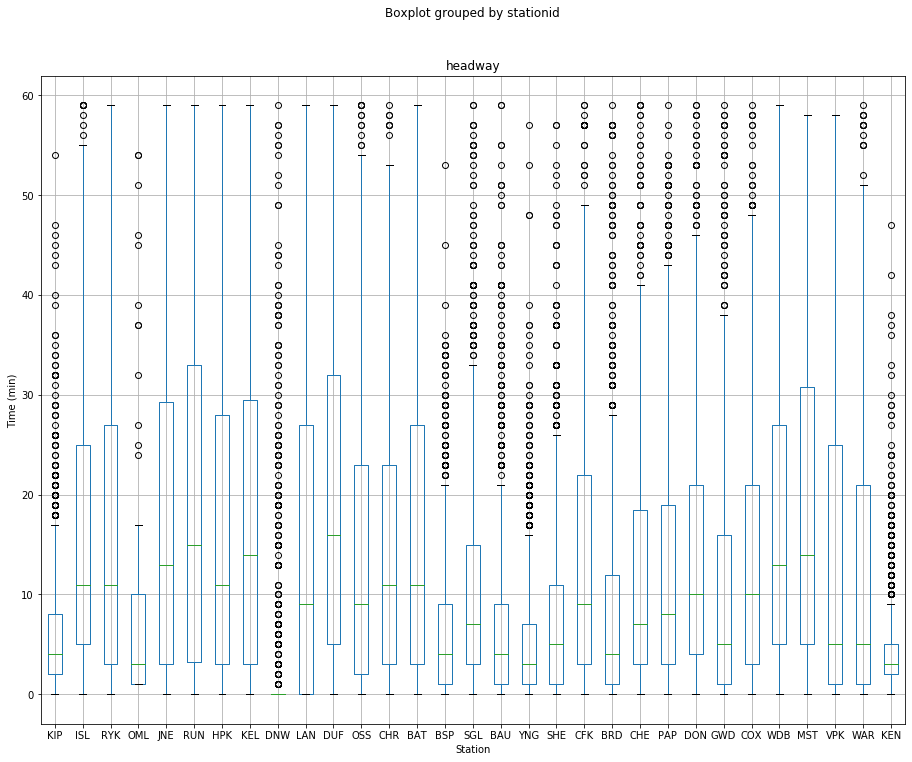

In [7]:

# sort stations from KIP to KEN
ttc_efa.sort_values(by=['stationid'], inplace=True);

plt.rcParams['figure.figsize'] = [15, 12];
f1 = ttc_efa.boxplot(column=['headway'],by='stationid');
f1.set_xticklabels(ttc_efa['station_char'].unique(), fontdict=None, minor=False);
f1.set_xlabel('Station');
f1.set_ylabel('Time (min)');


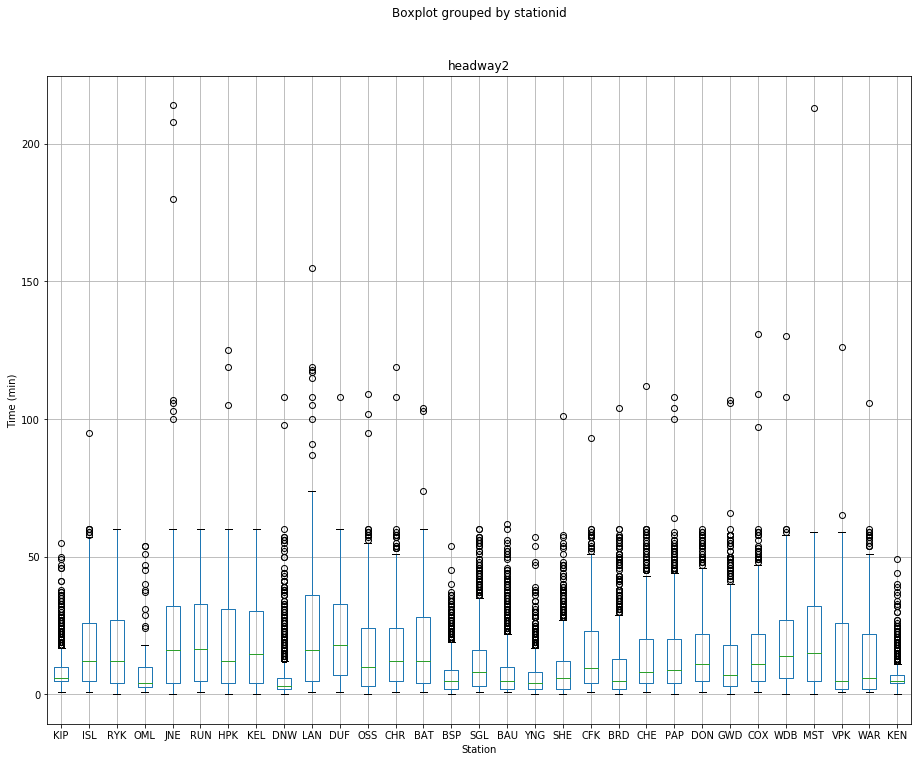

In [8]:
plt.rcParams['figure.figsize'] = [15, 12];
f1 = ttc_efa.boxplot(column=['headway2'],by='stationid');
f1.set_xticklabels(ttc_efa['station_char'].unique(), fontdict=None, minor=False);
f1.set_xlabel('Station');
f1.set_ylabel('Time (min)');

In [9]:
ttc_efa[['station_char','headway','headway2']].groupby('station_char').describe()

headway                                                      \
               count       mean        std  min   25%   50%    75%   max   
station_char                                                               
BAT            459.0  16.788671  16.144037  0.0  3.00  11.0  27.00  59.0   
BAU           1725.0   7.361159   8.919854  0.0  1.00   4.0   9.00  59.0   
BRD            877.0   9.387685  12.819176  0.0  1.00   4.0  12.00  59.0   
BSP           2185.0   6.079634   6.248888  0.0  1.00   4.0   9.00  53.0   
CFK            376.0  14.837766  15.788021  0.0  3.00   9.0  22.00  59.0   
CHE            679.0  12.474227  13.728794  0.0  3.00   7.0  18.50  59.0   
CHR            574.0  15.576655  14.450622  0.0  3.00  11.0  23.00  59.0   
COX            666.0  13.840841  13.286385  0.0  3.00  10.0  21.00  59.0   
DNW           1491.0   2.423206   8.016759  0.0  0.00   0.0   0.00  59.0   
DON            794.0  14.324937  13.373015  0.0  4.00  10.0  21.00  59.0   
DUF            186.0  20.526882  17.347695  0.0  5.00  16.0  32.00  59.0   
GWD            705.0  10.747518  13.776475  0.0  1.00   5.0  16.00  59.0   
HPK            201.0  17.273632  17.292477  0.0  3.00  11.0  28.00  59.0   
ISL            555.0  16.245045  15.006898  0.0  5.00  11.0  25.00  59.0   
JNE            240.0  17.550000  16.357077  0.0  3.00  13.0  29.25  59.0   
KEL            180.0  18.033333  16.361796  0.0  3.00  14.0  29.50  59.0   
KEN           2311.0   4.440069   4.159871  0.0  2.00   3.0   5.00  47.0   
KIP           1743.0   6.162364   6.231703  0.0  2.00   4.0   8.00  54.0   
LAN            251.0  15.984064  17.463326  0.0  0.00   9.0  27.00  59.0   
MST            258.0  18.379845  15.841724  0.0  5.00  14.0  30.75  58.0   
OML             75.0   9.640000  14.229433  1.0  1.00   3.0  10.00  54.0   
OSS            547.0  14.729433  15.872890  0.0  2.00   9.0  23.00  59.0   
PAP            689.0  13.000000  13.793536  0.0  3.00   8.0  19.00  59.0   
RUN            206.0  20.029126  17.927745  0.0  3.25  15.0  33.00  59.0   
RYK            420.0  16.730952  15.979745  0.0  3.00  11.0  27.00  59.0   
SGL           1121.0  10.836753  11.475561  0.0  3.00   7.0  15.00  59.0   
SHE           1577.0   8.225745   9.058735  0.0  1.00   5.0  11.00  57.0   
VPK            105.0  13.790476  16.891449  0.0  1.00   5.0  25.00  58.0   
WAR            597.0  12.887772  15.056130  0.0  1.00   5.0  21.00  59.0   
WDB            433.0  18.041570  15.783199  0.0  5.00  13.0  27.00  59.0   
YNG           2391.0   5.286491   5.864465  0.0  1.00   3.0   7.00  57.0   

             headway2                                                      
                count       mean        std  min  25%   50%    75%    max  
station_char                                                               
BAT             459.0  18.135076  17.155698  1.0  4.0  12.0  28.00  104.0  
BAU            1725.0   8.047536   8.914134  1.0  2.0   5.0  10.00   62.0  
BRD             877.0  10.389966  13.049459  0.0  2.0   5.0  13.00  104.0  
BSP            2185.0   6.596796   6.206378  0.0  2.0   5.0   9.00   54.0  
CFK             376.0  16.029255  16.145231  1.0  4.0   9.5  23.00   93.0  
CHE             679.0  13.752577  14.066028  1.0  4.0   8.0  20.00  112.0  
CHR             574.0  16.736934  15.433881  1.0  5.0  12.0  24.00  119.0  
COX             666.0  15.409910  14.788183  1.0  5.0  11.0  22.00  131.0  
DNW            1491.0   5.594903   8.612981  0.0  2.0   3.0   6.00  108.0  
DON             794.0  15.200252  13.255143  1.0  5.0  11.0  21.75   60.0  
DUF             186.0  22.037634  18.194852  1.0  7.0  18.0  32.75  108.0  
GWD             705.0  12.802837  14.375128  0.0  3.0   7.0  18.00  107.0  
HPK             201.0  19.870647  20.831783  0.0  4.0  12.0  31.00  125.0  
ISL             555.0  17.111712  15.239903  1.0  5.0  12.0  26.00   95.0  
JNE             240.0  22.558333  27.843044  0.0  4.0  16.0  32.00  214.0  
KEL             180.0  18.933333  16.087957  0.0  4.0  14.5 

In [10]:
# find headway=0 trains
ttc_6=ttc_5.reset_index(drop=True)
x = np.where(ttc_6['headway'] ==0);
m = ttc_6.loc[x];
m = pd.concat([m,ttc_6.loc[(x+np.ones(len(x), int)).flatten()]],axis=0);
m.sort_index(inplace=True);
m.sort_values(by=['station_char','trainid'],inplace=True)
m

,Unnamed: 0,requestid,id,station_char,subwayline,timint,traindirection,trainid,train_message,train_dest,...,date,time,day_of_week,rd2,time2,tid2,timint2,date2,headway,headway2
13,7511295,1327288,29399270928,BAT,BD,0.000000,East,216,AtStation,Westbound<br/> To Kipling,...,2019-04-01,14:42:37.044316,0,2019-04-01 14:40:39.354109-04:00,14:40:39.354109,216,1.764802,2019-04-01,0.0,104.0
14,7392055,1306828,29401359939,BAT,BD,1.586704,East,216,Arriving,Westbound<br/> To Kipling,...,2019-04-01,16:26:46.338862,0,2019-04-01 14:42:37.044316-04:00,14:42:37.044316,216,0.000000,2019-04-01,0.0,2.0
14,7392055,1306828,29401359939,BAT,BD,1.586704,East,216,Arriving,Westbound<br/> To Kipling,...,2019-04-01,16:26:46.338862,0,2019-04-01 14:42:37.044316-04:00,14:42:37.044316,216,0.000000,2019-04-01,0.0,2.0
15,7520001,1328758,29401406573,BAT,BD,0.000000,East,216,AtStation,Westbound<br/> To Kipling,...,2019-04-01,16:28:47.426774,0,2019-04-01 16:26:46.338862-04:00,16:26:46.338862,216,1.586704,2019-04-01,59.0,60.0
101,1754238,313406,29485699828,BAT,BD,0.000000,East,218,AtStation,Westbound<br/> To Kipling,...,2019-04-05,09:16:42.795752,4,2019-04-05 09:14:45.637856-04:00,09:14:45.637856,218,0.297850,2019-04-05,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25455,6849431,1213376,29975422542,YNG,BD,0.000000,East,248,AtStation,Eastbound</br> To Kennedy,...,2019-04-25,08:46:53.759285,3,2019-04-25 08:44:44.780445-04:00,08:44:44.780445,248,1.249117,2019-04-25,0.0,1.0
25794,6489830,1150729,30103212447,YNG,BD,0.000000,East,248,AtStation,Eastbound</br> To Kennedy,...,2019-04-30,10:48:49.171239,1,2019-04-30 10:46:49.313487-04:00,10:46:49.313487,248,0.828659,2019-04-30,17.0,17.0
24260,7699366,1359897,29588833914,YNG,BD,0.815871,East,249,Delayed,Eastbound</br> To Kennedy,...,2019-04-09,16:04:51.026943,1,2019-04-09 16:02:49.023076-04:00,16:02:49.023076,249,0.815871,2019-04-09,5.0,7.0
25456,6825191,1209309,29975456256,YNG,BD,0.000000,East,249,AtStation,Eastbound</br> To Kennedy,...,2019-04-25,08:48:43.641332,3,2019-04-25 08:46:53.759285-04:00,08:46:53.759285,249,0.819466,2019-04-25,2.0,4.0


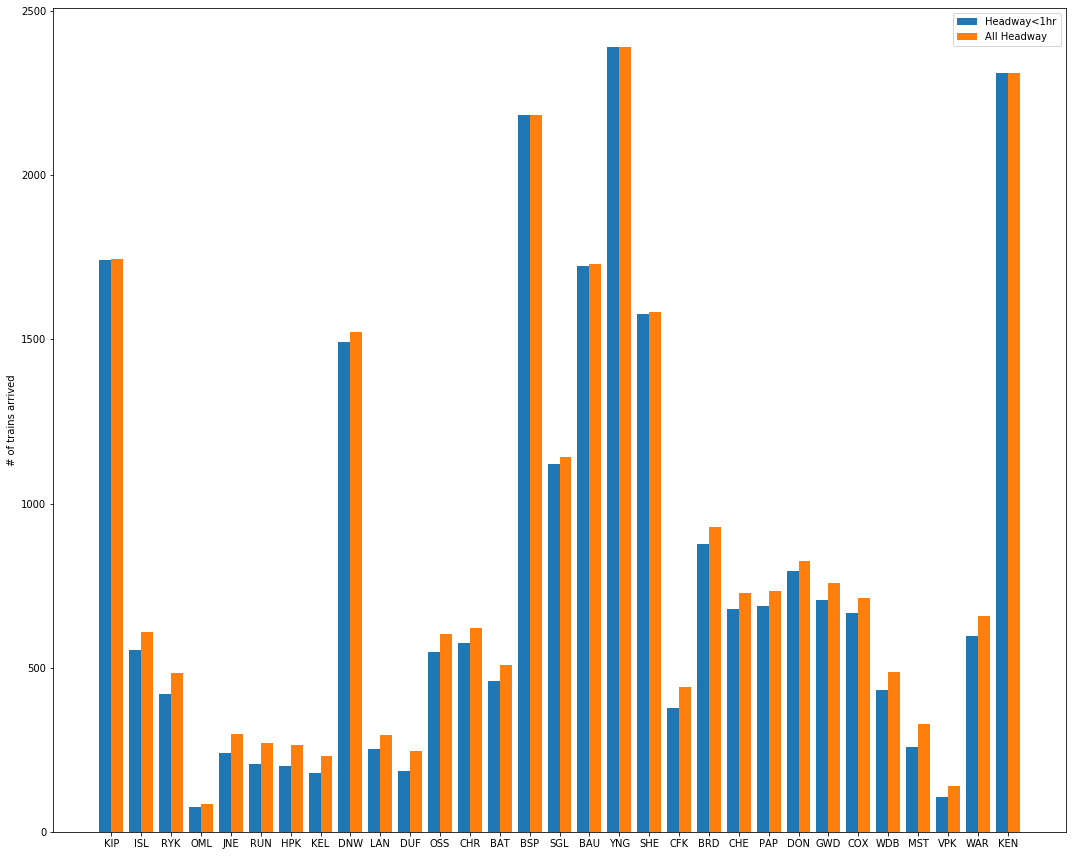

In [14]:
# plot number of arrivals per station
labels = ttc_efa['station_char'].unique();
x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, ttc_efa.groupby('stationid').headway.count(), width, label='Headway<1hr')
rects2 = ax.bar(x + width/2, ttc_5.groupby('stationid').headway.count(), width, label='All Headway')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('# of trains arrived')
#ax.set_title(' ')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()